# 1. Imports and Set Up

In [1]:
import sys
sys.path.append('../')
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from scripts.classification_utils import *
from scripts.visualization_utils import *
from scripts.evaluation_utils import *
import csv
import os
from itertools import zip_longest
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from fairlearn.reductions import ExponentiatedGradient, GridSearch, DemographicParity, EqualizedOdds, \
    TruePositiveRateParity, FalsePositiveRateParity, ErrorRateParity, BoundedGroupLoss
from fairlearn.metrics import *
from raiwidgets import FairnessDashboard
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 0. IMPORTANT--Specify classifier to be trained and dataset

In [2]:
models = {'Decision Tree': 'dt', 'Gaussian Naive Bayes':'gnb','Logistic Regression': 'lgr', 'Gradient_Boosted_Trees': 'gbt'}
#constraints = {'DemograficParity': 'DP', 'DemograficParity': 'EO', 'DemograficParity': 'EOO', 'DemograficParity': 'FPRP', 'DemograficParity': 'ERP'}
#reduction_algorithms = {'Exponential Gradient':'EG','Grid Search':'GS'}

data_path = '../data/final/unbalanced_set_100_42.csv'
results_path = '../data/results/notebook/'
model_name = models['Logistic Regression']
weight_idx = 1
testset_size = 0.3
total_num_samples_in_sets = [16000,6000]
save = True




In [3]:
os.makedirs(f'../data/results/notebook/{model_name}', exist_ok=True)


Folder exists


In [4]:
models_dict = {}
overall_results_dict = {}
black_results_dict = {}
white_results_dict = {}
all_scores = []
scores_names = []

# 2. Prepare data

In [5]:
data = get_data(data_path)

In [6]:
print(type(data))
print(data)

<class 'pandas.core.frame.DataFrame'>
       score  repay_probability  race  repay_indices
0        749              98.08     1              1
1        761              98.35     1              1
2        448              15.31     1              0
3        750              98.13     1              1
4        799              98.76     1              1
...      ...                ...   ...            ...
99995    511              14.06     0              0
99996    673              93.15     1              1
99997    750              98.13     1              1
99998    348               2.07     0              0
99999    390               7.96     1              0

[100000 rows x 4 columns]


In [10]:
X_train, X_test, y_train, y_test, race_train, race_test, sample_weight_train, sample_weight_test = prep_data(data=data, test_size=testset_size, total_num_samples_in_sets = total_num_samples_in_sets, weight_index=weight_idx)

3000
3000


In [11]:
# split up X_test by race
X_test_b = []

X_test_w = []

for index in range(len(X_test)):
    if race_test[index] == 0:  # black
        X_test_b.append(X_test[index][0])
    elif race_test[index] == 1:  # white
        X_test_w.append(X_test[index][0])

# given predictions+outcomes, I'll need to do the same 

In [12]:
#adding scores to list
all_scores.extend([X_test_b,X_test_w])
scores_names.extend(['testB', 'testW'])

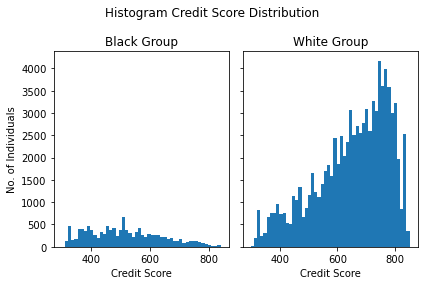

In [13]:
# make histogram of credit scores by race
visual_scores_by_race(data)

(array([ 20.,  76.,  17.,  33.,  66.,  60.,  75.,  80.,  63.,  53.,  38.,
         78.,  52.,  89., 102.,  79.,  99.,  73., 147., 117.,  78., 149.,
        152., 158., 142., 157., 168., 208., 147., 221., 248., 235., 222.,
        254., 231., 292., 270., 176., 288., 286., 322., 342., 323., 316.,
        311., 359., 110., 150., 180.,  88.]),
 array([312.  , 322.68, 333.36, 344.04, 354.72, 365.4 , 376.08, 386.76,
        397.44, 408.12, 418.8 , 429.48, 440.16, 450.84, 461.52, 472.2 ,
        482.88, 493.56, 504.24, 514.92, 525.6 , 536.28, 546.96, 557.64,
        568.32, 579.  , 589.68, 600.36, 611.04, 621.72, 632.4 , 643.08,
        653.76, 664.44, 675.12, 685.8 , 696.48, 707.16, 717.84, 728.52,
        739.2 , 749.88, 760.56, 771.24, 781.92, 792.6 , 803.28, 813.96,
        824.64, 835.32, 846.  ]),
 <BarContainer object of 50 artists>)

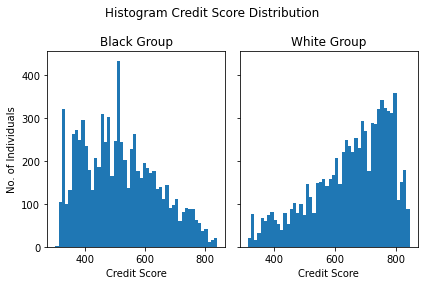

In [14]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

fig.suptitle('Histogram Credit Score Distribution')
plt.xlabel('Credit Score')
#plt.ylabel('No. of Individuals')

black_credit_dist = X_train[np.where(X_train[:, 1] == 0)[0]][:,0]
white_credit_dist = X_train[np.where(X_train[:, 1] == 1)[0]][:,0]
n_bins = 50
# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(black_credit_dist, bins=n_bins)
axs[0].set_title('Black Group')
axs[0].set_xlabel('Credit Score')
axs[0].set_ylabel('No. of Individuals')
axs[1].set_title('White Group')
axs[1].hist(white_credit_dist, bins=n_bins)


(array([  5.,  29.,   4.,  18.,  15.,  21.,  24.,  25.,  22.,  20.,  28.,
         17.,  21.,  46.,  39.,  39.,  20.,  28.,  61.,  53.,  44.,  25.,
         62.,  88.,  41.,  74.,  65.,  76.,  83.,  70.,  98.,  94., 105.,
         70.,  93.,  95., 122.,  74., 118., 109., 136., 108., 125., 117.,
         89., 116.,  36.,  56.,  62.,  14.]),
 array([312.  , 322.76, 333.52, 344.28, 355.04, 365.8 , 376.56, 387.32,
        398.08, 408.84, 419.6 , 430.36, 441.12, 451.88, 462.64, 473.4 ,
        484.16, 494.92, 505.68, 516.44, 527.2 , 537.96, 548.72, 559.48,
        570.24, 581.  , 591.76, 602.52, 613.28, 624.04, 634.8 , 645.56,
        656.32, 667.08, 677.84, 688.6 , 699.36, 710.12, 720.88, 731.64,
        742.4 , 753.16, 763.92, 774.68, 785.44, 796.2 , 806.96, 817.72,
        828.48, 839.24, 850.  ]),
 <BarContainer object of 50 artists>)

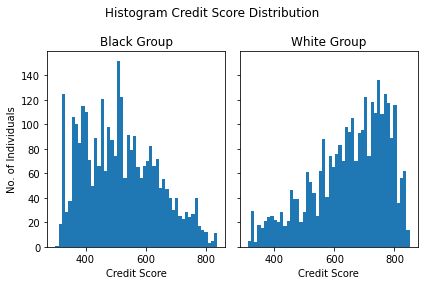

In [15]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

fig.suptitle('Histogram Credit Score Distribution')
plt.xlabel('Credit Score')
#plt.ylabel('No. of Individuals')

black_credit_dist = X_test[np.where(X_test[:, 1] == 0)[0]][:,0]
white_credit_dist = X_test[np.where(X_test[:, 1] == 1)[0]][:,0]
n_bins = 50
# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(black_credit_dist, bins=n_bins)
axs[0].set_title('Black Group')
axs[0].set_xlabel('Credit Score')
axs[0].set_ylabel('No. of Individuals')
axs[1].set_title('White Group')
axs[1].hist(white_credit_dist, bins=n_bins)


In [ ]:
visual_repay_dist(data)

# 3. Classifier

In [ ]:
print('The classifier trained below is: ', model_name)

results_path += f'{model_name}/'

In [ ]:
classifier = get_classifier(model_name)

## Train classifier and collect predictions
NOTE: atm sample_weight are all 1s

In [ ]:
# Reference: https://www.datacamp.com/community/tutorials/decision-tree-classification-python
np.random.seed(0)

# Train the classifier:
model = classifier.fit(X_train,y_train, sample_weight_train)

# Make predictions with the classifier:
y_predict = model.predict(X_test)

# Scores on test set
test_scores = model.predict_proba(X_test)[:, 1]

### Get new scores by race

In [ ]:
# think: later on I might want to create a sheet just with the TP and FP scores by race specifically
X_unmit_b, X_unmit_w,_,_ = get_new_scores(X_test, y_predict, y_test, race_test)

In [ ]:
#adding scores to list
all_scores.extend([X_unmit_b,X_unmit_w])
scores_names.extend(['unmitB', 'unmitW'])

### Evaluation of classifier overall

In [ ]:
# Metrics
models_dict = {"Unmitigated": (y_predict, test_scores)}
get_metrics_df(models_dict, y_test, race_test)

### Cross-validated metrics

In [ ]:
x = data[['score', 'race']].values
y = data['repay_indices'].values

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, x, y, cv=5, scoring='f1_weighted')
print(scores)

### Delayed impact calculated
### Fairness Metric Evaluation of classifier
### Evaluation of classifier by race

In [ ]:
constraint_str = 'Un-'
results_overall, results_black, results_white = evaluating_model(constraint_str,X_test,y_test, y_predict, sample_weight_test,race_test)

### Save results to dictionaries

In [ ]:
run_key = f'{model_name} Unmitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

## Exponentiated Gradient Reduction Alg for Adding Fairness Constraints

In [ ]:
from IPython.display import display, HTML
display(HTML("<style>div.output_scroll { height: 60em; }</style>"))

### Demographic Parity

In [ ]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'DP', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

### Get new scores by race

In [ ]:
### Get new scores by race
X_egDP_b, X_egDP_w,_,_ = get_new_scores(X_test, y_pred_mitigated, y_test, race_test)

In [ ]:
#adding scores to list
all_scores.extend([X_egDP_b, X_egDP_w])
scores_names.extend(['egdpB', 'egdpW'])

### Save results to dictionaries

In [ ]:
run_key = f'{model_name} EG DP Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

### Equalized Odds

In [ ]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'EO', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

### Get new scores by race

In [ ]:
X_egEO_b, X_egEO_w,_,_ = get_new_scores(X_test, y_pred_mitigated, y_test, race_test)

In [ ]:
#adding scores to list
all_scores.extend([X_egEO_b, X_egEO_w])
scores_names.extend(['egeoB', 'egeoW'])

### Save results to dictionaries

In [ ]:
run_key = f'{model_name} EG EO Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

### EOO (True Positive Rate Parity)

In [ ]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'TPRP', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

### Get new scores by race

In [ ]:
X_egEOO_b, X_egEOO_w,_,_ = get_new_scores(X_test, y_pred_mitigated, y_test, race_test)

In [ ]:
#adding scores to list
all_scores.extend([X_egEOO_b, X_egEOO_w])
scores_names.extend(['egeooB', 'egeooW'])

### Save results to dictionaries

In [ ]:
run_key = f'{model_name} EG EOO Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

### False Positive Rate Parity

In [ ]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'FPRP', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

### Get new scores by race

In [ ]:
X_egFPRP_b, X_egFPRP_w,_,_ = get_new_scores(X_test, y_pred_mitigated, y_test, race_test)

In [ ]:
#adding scores to list
all_scores.extend([X_egFPRP_b, X_egFPRP_w])
scores_names.extend(['egfprpB', 'egfprpW'])

### Save results to dictionaries

In [ ]:
run_key = f'{model_name} EG FPRP Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

### Error Rate Parity

In [ ]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'ERP', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

### Get new scores by race

In [ ]:
X_egERP_b, X_egERP_w,_,_ = get_new_scores(X_test, y_pred_mitigated, y_test, race_test)

In [ ]:
#adding scores to list
all_scores.extend([X_egERP_b, X_egERP_w])
scores_names.extend(['egerpB', 'egerpW'])

### Save results to dictionaries

In [ ]:
run_key = f'{model_name} EG ERP Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

## Grid Search Reduction Alg for Adding Fairness Constraints

### Demographic Parity

In [ ]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'DP', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

In [ ]:
# We can examine the values of lambda_i chosen for us:
lambda_vecs = mitigator.lambda_vecs_
print(lambda_vecs[0])

The next few cells come from: https://github.com/fairlearn/fairlearn/blob/main/notebooks/Binary%20Classification%20with%20the%20UCI%20Credit-card%20Default%20Dataset.ipynb

Note: we train multiple models corresponding to different trade-off points between the performance metric (balanced accuracy) and fairness metric.

In [ ]:
grid_search_show(mitigator, demographic_parity_difference, y_pred_mitigated, X_test, y_test, race_test, 'DemParityDifference','GS DPD', models_dict, 0.3)

In [ ]:
models_dict.pop('GS DPD')
models_dict

### Get new scores by race

In [ ]:
X_gsDP_b, X_gsDP_w,_,_ = get_new_scores(X_test, y_pred_mitigated, y_test, race_test)

In [ ]:
#adding scores to list
all_scores.extend([X_gsDP_b, X_gsDP_w ])
scores_names.extend(['gsdpB', 'gsdpW'])

### Save results to dictionaries

In [ ]:
run_key = f'{model_name} GS DP Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

### Equalized Odds Used

In [ ]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'EO', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

In [ ]:
# We can examine the values of lambda_i chosen for us:
lambda_vecs = mitigator.lambda_vecs_
print(lambda_vecs[0])

In [ ]:
grid_search_show(mitigator, equalized_odds_difference, y_pred_mitigated, X_test, y_test, race_test, 'EOddsDifference','GS EO', models_dict, 0.3)

In [ ]:
models_dict.pop('GS EO')
models_dict

### Get new scores by race

In [ ]:
X_gsEO_b, X_gsEO_w,_,_ = get_new_scores(X_test, y_pred_mitigated, y_test, race_test)

In [ ]:
#adding scores to list
all_scores.extend([X_gsEO_b, X_gsEO_w])
scores_names.extend(['gseoB', 'gseoW'])

### Save results to dictionaries

In [ ]:
run_key = f'{model_name} GS EO Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

### EOO (True Positive Rate Parity)

In [ ]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'TPRP', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

In [ ]:
# We can examine the values of lambda_i chosen for us:
lambda_vecs = mitigator.lambda_vecs_
print(lambda_vecs[0])

In [ ]:
grid_search_show(mitigator, true_positive_rate_difference, y_pred_mitigated, X_test, y_test, race_test, 'TPRPDifference','GS TPRP', models_dict, 0.3)

In [ ]:
models_dict.pop('GS TPRP')
models_dict

### Get new scores by race

In [ ]:
X_gsEOO_b, X_gsEOO_w,_,_ = get_new_scores(X_test, y_pred_mitigated, y_test, race_test)

In [ ]:
#adding scores to list
all_scores.extend([X_gsEOO_b, X_gsEOO_w])
scores_names.extend(['gseooB', 'gseooW'])

### Save results to dictionaries

In [ ]:
run_key = f'{model_name} GS EOO Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

### False Positive Rate Parity

In [ ]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'FPRP', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

In [ ]:
# We can examine the values of lambda_i chosen for us:
lambda_vecs = mitigator.lambda_vecs_
print(lambda_vecs[0])

In [ ]:
# NOTE: the below models are the same for DT classifier!!

In [ ]:
grid_search_show(mitigator, false_positive_rate_difference, y_pred_mitigated, X_test, y_test, race_test, 'FPRPDifference','GS FPRP', models_dict, 0.4)

In [ ]:
models_dict.pop('GS FPRP')
models_dict

### Get scores by race

In [ ]:
X_gsFPRP_b, X_gsFPRP_w,_,_ = get_new_scores(X_test, y_pred_mitigated, y_test, race_test)

In [ ]:
#adding scores to list
all_scores.extend([X_gsFPRP_b, X_gsFPRP_w])
scores_names.extend(['gsfprpB', 'gsfprpW'])

### Save results to dictionaries

In [ ]:
run_key = f'{model_name} GS FPRP Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

### Error Rate Parity

In [ ]:
mitigator, results_overall, results_black, results_white, y_pred_mitigated = add_constraint(model, 'ERP', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

In [ ]:
# We can examine the values of lambda_i chosen for us:
lambda_vecs = mitigator.lambda_vecs_
print(lambda_vecs[0])

In [ ]:
# Fairlearn doesnt have an erp difference metric for the below
#grid_search_show(gs_erp, error_difference, y_predict, X_test, y_test, race_test, 'ERDifference','GS ERP', models_dict, 0.3)
#models_dict.pop('GS FPRP')
#models_dict

### Get scores by race

In [ ]:
X_gsERP_b, X_gsERP_w,_,_ = get_new_scores(X_test, y_pred_mitigated, y_test, race_test)

In [ ]:
#adding scores to list
all_scores.extend([X_gsERP_b, X_gsERP_w])
scores_names.extend(['gserpB', 'gserpW'])

### Save results to dictionaries

In [ ]:
run_key = f'{model_name} GS ERP Mitigated'
print(run_key)
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

# 4. Save results to csv files

In [ ]:
# To use below!!
if save == True:
    overall_fieldnames = ['Run', 'Acc', 'ConfMatrix','F1micro', 'F1weighted','F1binary', 'SelectionRate', 'TNR rate', 'TPR rate', 'FNER', 'FPER', 'DIB','DIW', 'DP Diff', 'EO Diff', 'TPR Diff', 'FPR Diff', 'ER Diff']
    byrace_fieldnames = ['Run', 'Acc', 'ConfMatrix','F1micro', 'F1weighted','F1binary', 'SelectionRate', 'TNR rate', 'TPR rate', 'FNER', 'FPER', 'DI']
    save_dict_in_csv(overall_results_dict, overall_fieldnames,  results_path+model_name+'_overall_results.csv')
    save_dict_in_csv(black_results_dict, byrace_fieldnames,  results_path+model_name+'_black_results.csv')
    save_dict_in_csv(white_results_dict, byrace_fieldnames,  results_path+model_name+'_white_results.csv')

In [ ]:
if save == True:
    # Save overall score results
    columns_data = zip_longest(*all_scores)

    with open(results_path+model_name+'_all_scores.csv',mode='w') as f:
        writer = csv.writer(f)
        writer.writerow(scores_names)
        writer.writerows(columns_data)
        f.close()